# Assignment 1B - Question 1
## Training and Adapting Deep Networks

In [11]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from scipy.io import loadmat

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.preprocessing.image import Iterator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



### Load data from training and testing sets

Use scipy.io loadmat function

In [12]:
train = loadmat('Data/Q1/q1_train.mat')
test = loadmat('Data/Q1/q1_test.mat')

### Sanity check

In [3]:
train['train_Y'].shape

(1000, 1)

In [4]:
test['test_Y'].shape

(10000, 1)

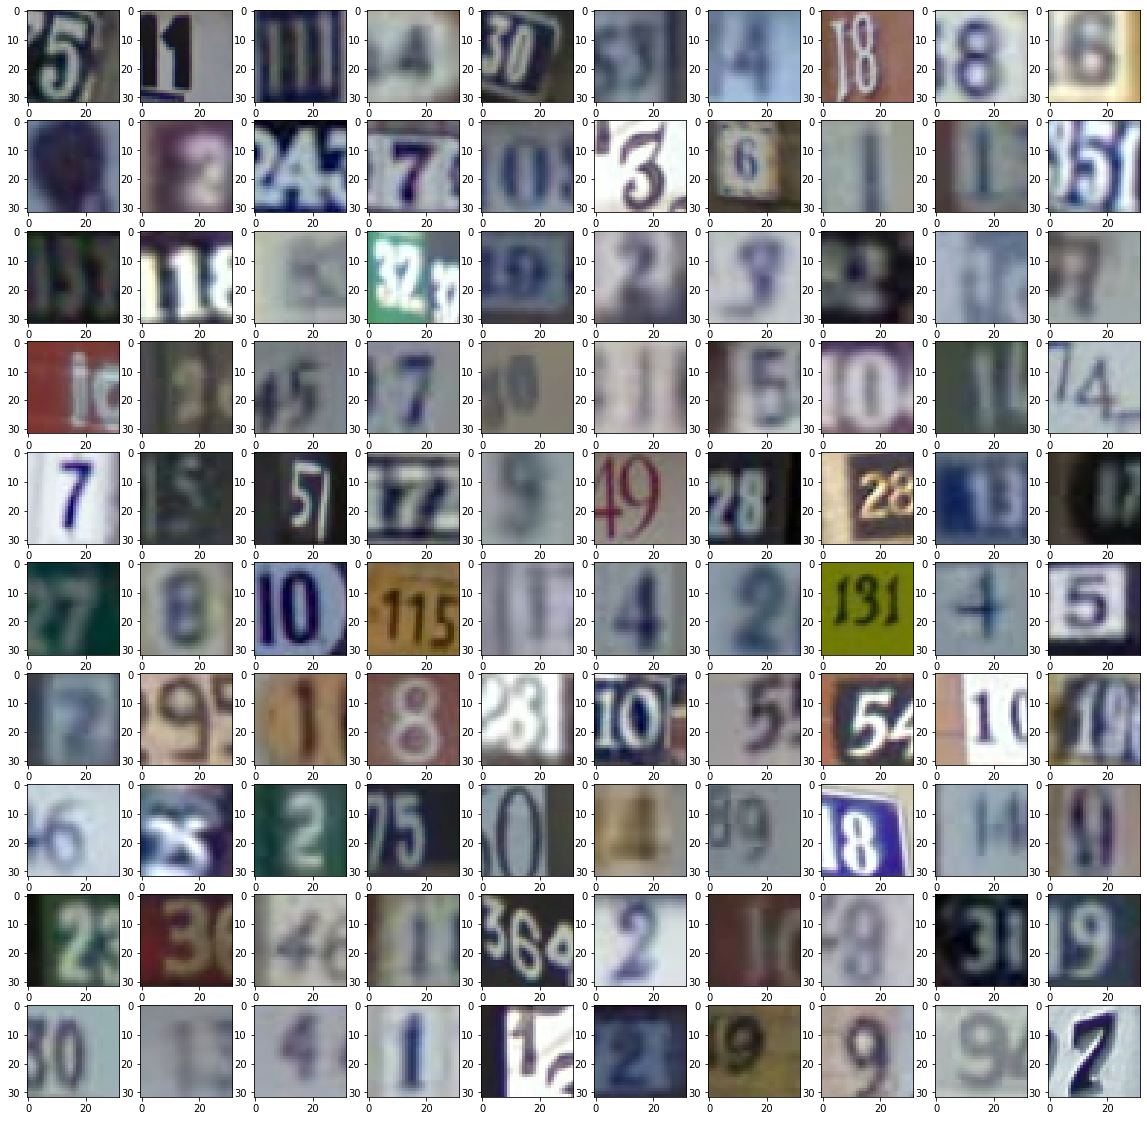

In [13]:
(x_test, y_test) = (test['test_X'], test['test_Y'])
x_test = x_test.astype('float32') / 255
x_test = np.transpose(x_test, (3,0,1,2))
fig = plt.figure(figsize=[20, 20])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_test[i,:,:,:])

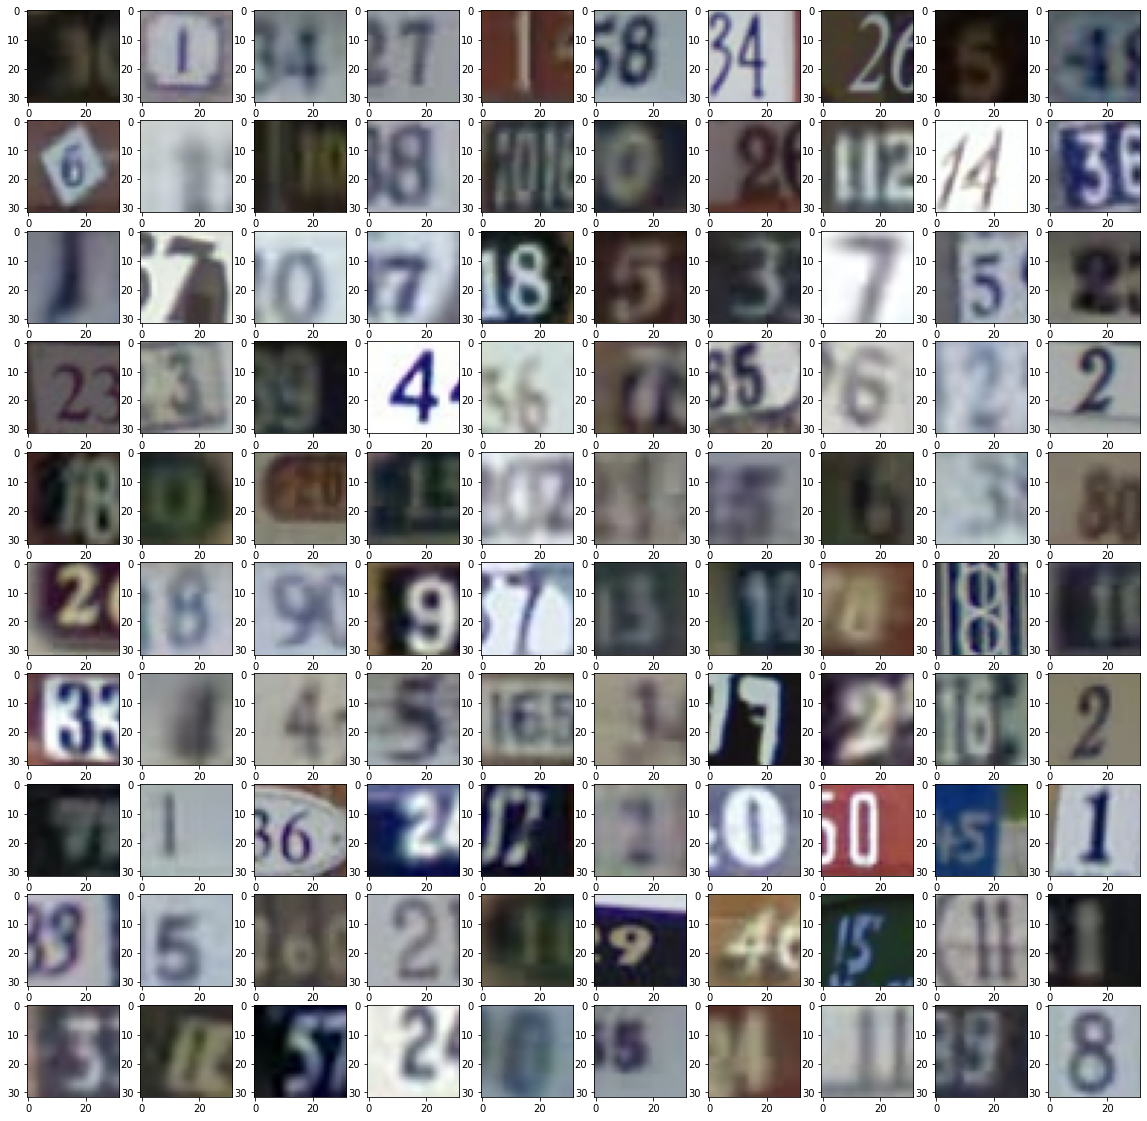

In [6]:
(x_train, y_train) = (train['train_X'], train['train_Y'])
x_train = x_train.astype('float32') / 255
x_train = np.transpose(x_train, (3,0,1,2))
fig = plt.figure(figsize=[20, 20])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_train[i,:,:,:])

### Keras Model

Taken from Week 4 example 2

In [6]:
def get_model_no_weights():
    model = keras.models.load_model('vgg_2stage_CIFAR_bigger.h5')

    x = layers.Dense(64, activation='relu')(model.layers[-6].output)
    outputs = layers.Dense(11)(x)

    new_model = keras.Model(inputs=model.input, outputs=outputs)
    config = new_model.get_config()
    new_model = keras.Model.from_config(config)
    
    return new_model

In [8]:
model_cnn = get_model_no_weights()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
history = model_cnn.fit(x_train, y_train,
                        batch_size=32,
                        epochs=50,
                        validation_split=0.2, verbose=True)

Epoch 1/50
25/25 [==============================] - 2s 27ms/step - loss: 2.3444 - accuracy: 0.1517 - val_loss: 2.2529 - val_accuracy: 0.1600
Epoch 2/50
25/25 [==============================] - 0s 19ms/step - loss: 2.2911 - accuracy: 0.1643 - val_loss: 2.2318 - val_accuracy: 0.1600
Epoch 3/50
25/25 [==============================] - 0s 19ms/step - loss: 2.2612 - accuracy: 0.1930 - val_loss: 2.2117 - val_accuracy: 0.1750
Epoch 4/50
25/25 [==============================] - 0s 18ms/step - loss: 2.1937 - accuracy: 0.2223 - val_loss: 2.1870 - val_accuracy: 0.2100
Epoch 5/50
25/25 [==============================] - 1s 21ms/step - loss: 2.1553 - accuracy: 0.2164 - val_loss: 2.1277 - val_accuracy: 0.2500
Epoch 6/50
25/25 [==============================] - 1s 20ms/step - loss: 2.0724 - accuracy: 0.2491 - val_loss: 2.0878 - val_accuracy: 0.2400
Epoch 7/50
25/25 [==============================] - 0s 17ms/step - loss: 2.0078 - accuracy: 0.2936 - val_loss: 1.9928 - val_accuracy: 0.3150
Epoch 8/50
25

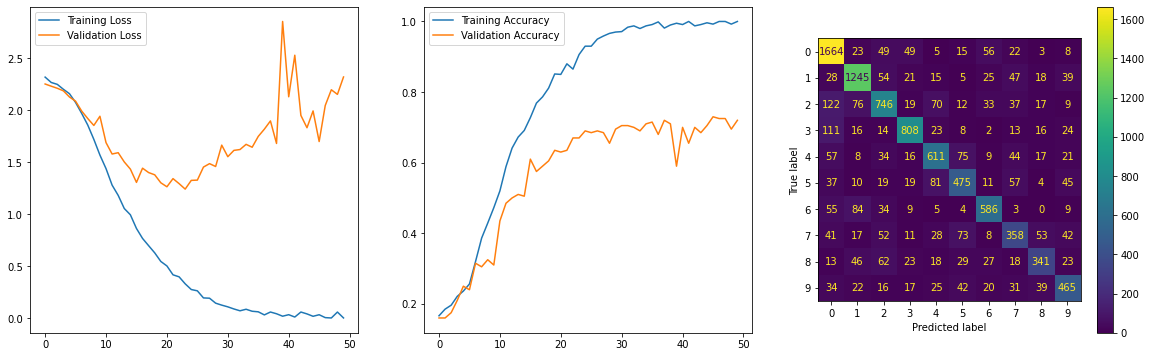

In [9]:
def plot_training(history, model, x_test, y_test):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 3, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 3, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend();
    
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)
    
    cm = confusion_matrix(y_test, indexes)
    ax = fig.add_subplot(1, 3, 3)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    
plot_training(history, model_cnn, x_test, y_test)

### Data Augmentation

Week 5 example 3

In [19]:
data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.05),
  layers.experimental.preprocessing.RandomZoom(0.025),
  layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.025, 0.025), width_factor=(-0.025, 0.025))
])

fig = plt.figure(figsize=[20, 25])
for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(10, 10, i*10 + (j + 1))
        augmented_image = data_augmentation(tf.expand_dims(x_train[i,:,:,:],0))
        plt.imshow(augmented_image[0])
        plt.axis("off")

NameError: name 'x_train' is not defined

In [ ]:
def get_model_no_weights_augment():
    inputs = keras.Input(shape=(32, 32, 3, ), name='img')
    augmented = data_augmentation(inputs)
    
    model = keras.models.load_model('vgg_2stage_CIFAR_bigger.h5')
    x = layers.Dense(64, activation='relu')(model.layers[-6].output)
    outputs = layers.Dense(11)(x)

    new_model = keras.Model(inputs=augmented, outputs=outputs)
    config = new_model.get_config()
    new_model = keras.Model.from_config(config)
    
    return model_cnn_aug

In [18]:
model_cnn_aug.summary()

Model: "SVHN_CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)       

In [12]:
model_cnn_aug = get_model_no_weights_augment()
model_cnn_aug.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
history = model_cnn_aug.fit(x_train, y_train,
                        batch_size=32,
                        epochs=100,
                        validation_split=0.2, verbose=True)

Epoch 1/100
25/25 [==============================] - 4s 59ms/step - loss: 2.3719 - accuracy: 0.1426 - val_loss: 2.3129 - val_accuracy: 0.1600
Epoch 2/100
25/25 [==============================] - 1s 35ms/step - loss: 2.3006 - accuracy: 0.1634 - val_loss: 2.2430 - val_accuracy: 0.1600
Epoch 3/100
25/25 [==============================] - 1s 44ms/step - loss: 2.2710 - accuracy: 0.1808 - val_loss: 2.2511 - val_accuracy: 0.1600
Epoch 4/100
25/25 [==============================] - 1s 32ms/step - loss: 2.2617 - accuracy: 0.1801 - val_loss: 2.2785 - val_accuracy: 0.1600
Epoch 5/100
25/25 [==============================] - 1s 32ms/step - loss: 2.2703 - accuracy: 0.1804 - val_loss: 2.2147 - val_accuracy: 0.2000
Epoch 6/100
25/25 [==============================] - 1s 34ms/step - loss: 2.2515 - accuracy: 0.2222 - val_loss: 2.2411 - val_accuracy: 0.1700
Epoch 7/100
25/25 [==============================] - 1s 32ms/step - loss: 2.2290 - accuracy: 0.2129 - val_loss: 2.2071 - val_accuracy: 0.2050
Epoch 

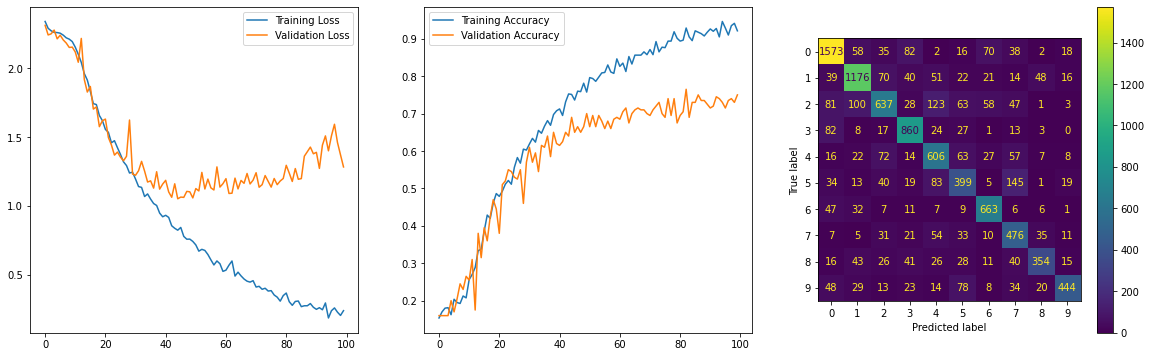

In [13]:
plot_training(history, model_cnn_aug, x_test, y_test)


### Fine Tuning on CIFAR

Week 5 example 3


In [5]:
model = keras.models.load_model('vgg_2stage_CIFAR_bigger.h5')

x = layers.Dense(64, activation='relu')(model.layers[-6].output)
# output layer, single value, as we only have 1 output - the 
outputs = layers.Dense(11)(x)

pre_train = keras.Model(inputs=model.input, outputs=outputs)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
activation_37 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
spatial_dropout2d_22 (Spatia (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 16, 16, 32)        4640

In [34]:
# train the model
pre_train.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])

history = pre_train.fit(x_train, y_train,
                        batch_size=64,
                        epochs=100,
                        validation_split=0.2, verbose=True)

Epoch 1/100
13/13 [==============================] - 4s 219ms/step - loss: 2.3363 - accuracy: 0.3118 - val_loss: 2.3226 - val_accuracy: 0.2800
Epoch 2/100
13/13 [==============================] - 2s 187ms/step - loss: 2.2921 - accuracy: 0.3077 - val_loss: 2.8642 - val_accuracy: 0.2100
Epoch 3/100
13/13 [==============================] - 3s 221ms/step - loss: 2.3861 - accuracy: 0.2728 - val_loss: 2.6477 - val_accuracy: 0.2150
Epoch 4/100
13/13 [==============================] - 3s 195ms/step - loss: 2.3245 - accuracy: 0.2750 - val_loss: 2.5043 - val_accuracy: 0.2550
Epoch 5/100
13/13 [==============================] - 3s 211ms/step - loss: 2.3630 - accuracy: 0.2664 - val_loss: 2.3666 - val_accuracy: 0.2600
Epoch 6/100
13/13 [==============================] - 3s 201ms/step - loss: 2.3097 - accuracy: 0.2833 - val_loss: 2.3871 - val_accuracy: 0.2650
Epoch 7/100
13/13 [==============================] - 2s 181ms/step - loss: 2.3399 - accuracy: 0.2726 - val_loss: 2.3376 - val_accuracy: 0.2600

KeyboardInterrupt: 

In [ ]:
plot_training(history, pre_train, x_test, y_test)